# Layer Relation

## 1. Setup

In [7]:
import hydra
import os

import torch
import torch.nn.functional as F

import pytorch_lightning as pl

from transformers import AutoModel, AutoModelForMaskedLM, AutoTokenizer, AutoConfig
from transformers import get_scheduler

In [5]:
with hydra.initialize('../configs'):
    config = hydra.compose('config.yaml', overrides=['working_dir=../', 'model.mlm=false'])

## 2. Model

In [15]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-small')
student = AutoModel.from_pretrained('klue/roberta-small', output_hidden_states=True, output_attentions=True)
teacher = AutoModel.from_pretrained('klue/roberta-base', output_hidden_states=True, output_attentions=True)

TypeError: __init__() got an unexpected keyword argument 'output_attention'

## 3. Layer Relation

In [8]:
def transpose_for_scores(h, num_heads):
    batch_size, seq_length, dim = h.size()
    head_size = dim // num_heads
    h = h.view(batch_size, seq_length, num_heads, head_size)
    return h.permute(0, 2, 1, 3)


def relation_attention(h1, h2, num_relation_heads, attention_mask=None):        
    h1 = transpose_for_scores(h1, num_relation_heads) # (batch, num_heads, seq_length, head_size)
    h2 = transpose_for_scores(h2, num_relation_heads) # (batch, num_heads, seq_length, head_size)

    attn = torch.matmul(h1, h2.transpose(-1, -2)) # (batch_size, num_heads, seq_length, seq_length)
    if attention_mask is not None:
        attention_mask = attention_mask[:, None, None, :]
        attention_mask = (1 - attention_mask) * -10000.0
        attn = attn + attention_mask

    
#     attn = attn.view(-1, attn.size(-1)) # (~, seq_length)
    return attn

def kl_div_loss(s, t, temperature=1.):
    s = F.log_softmax(s / temperature, dim=-1)
    t = F.softmax(t / temperature, dim=-1)
    return F.kl_div(s, t, reduction='batchmean')

In [9]:
text = ['조 교수는 육군사관학교 60기 출신으로 17년간 군 복무를 했다. 그는 이날 “작년까지만 해도 군복을 입고 있었다”며 “제복과 군복이 자랑스러울 수 있는 국가가 됐으면 하는 게 내 개인적 바람”이라고 스스로를 소개했다. 1982년생으로 서울에서 태어난 조 교수는 군 복무 중 이라크 자이툰부대, 한미연합사령부, 육군본부 정책실 등에서 근무한 뒤 지난해 육군 소령으로 전역했다. 2016년 미국 하버드대 케네디스쿨에서 공공행정학 석사 학위를 받는 등 학업도 병행했다. 지난해부터는 서경대 미래국방기술창업센터장으로 부임해 국내 우주산업과 방위산업 연구에 주력하고 있다.']

In [10]:
batch = tokenizer(text, max_length=512, padding='max_length', truncation=True, return_tensors='pt')

In [12]:
ho = teacher(**batch)
so = student(**batch)

th = to.hidden_states
sh = so.hidden_states

In [14]:
th

In [13]:
te = relation_attention(th[0], th[0], 48, batch.attention_mask) # teacher embedding attn
se = relation_attention(sh[0], sh[0], 48, batch.attention_mask) # student embedding attn

tl = relation_attention(th[-1], th[-1], 48, batch.attention_mask) # teacher last hidden state attn
sl = relation_attention(sh[-1], sh[-1], 48, batch.attention_mask) # student last hidden state attn

tel = relation_attention(th[0], th[-1], 48, batch.attention_mask) # teacher embedding -> last hidden attn
sel = relation_attention(sh[0], sh[-1], 48, batch.attention_mask) # student embedding -> last hidden attn

tle = relation_attention(th[-1], th[0], 48, batch.attention_mask) # teacher last hidden -> embedding attn
sle = relation_attention(sh[-1], sh[0], 48, batch.attention_mask) # student last hidden -> embedding attn

TypeError: 'NoneType' object is not subscriptable

In [22]:
s = tel.transpose(-1, -2) == tle

In [32]:
s[0][0][-1]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [16]:
tel.size(), tle.size()

(torch.Size([1, 48, 512, 512]), torch.Size([1, 48, 512, 512]))

In [166]:
loss_e = kl_div_loss(se, te)
loss_l = kl_div_loss(sl, tl)
loss_el = kl_div_loss(sel, tel)
loss_le = kl_div_loss(sle, tle)

In [167]:
loss_e, loss_l, loss_el, loss_le

(tensor(4.6449, grad_fn=<DivBackward0>),
 tensor(6.3919, grad_fn=<DivBackward0>),
 tensor(4.5353, grad_fn=<DivBackward0>),
 tensor(4.4880, grad_fn=<DivBackward0>))

In [160]:
loss_e, loss_l, loss_el, loss_le

(tensor(3.1986, grad_fn=<DivBackward0>),
 tensor(5.7497, grad_fn=<DivBackward0>),
 tensor(3.4266, grad_fn=<DivBackward0>),
 tensor(3.7151, grad_fn=<DivBackward0>))

In [105]:
t = relation_attention(outputs_t.hidden_states[0], outputs_t.hidden_states[-1], 48, batch.attention_mask)
s = relation_attention(outputs_s.hidden_states[0], outputs_s.hidden_states[-1], 48, batch.attention_mask)

In [108]:
t = relation_attention(outputs_t.hidden_states[-1], outputs_t.hidden_states[0], 48, batch.attention_mask)
s = relation_attention(outputs_s.hidden_states[-1], outputs_s.hidden_states[0], 48, batch.attention_mask)

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

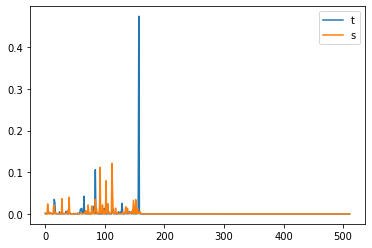

In [106]:
idx = 1006
sns.lineplot(x=range(512), y=t[idx].detach().softmax(dim=0))
sns.lineplot(x=range(512), y=s[idx].detach().softmax(dim=0))
plt.legend(['t', 's'])

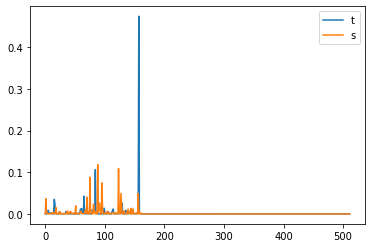

In [100]:
idx = 1006
sns.lineplot(x=range(512), y=t[idx].detach().softmax(dim=0))
sns.lineplot(x=range(512), y=s[idx].detach().softmax(dim=0))
plt.legend(['t', 's'])

In [80]:
t[20001].softmax(dim=0).sum()

tensor(1.)

In [49]:
embed_attn_s1 = relation_attention(embed_s, 48, batch.attention_mask)
embed_attn_t1 = relation_attention(embed_t, 48, batch.attention_mask)

In [50]:
embed_attn_s1.size()

torch.Size([49152, 512])

In [52]:
(embed_attn_s == embed_attn_s1).float().mean()

tensor(1.)

In [109]:
F.kl_div(F.log_softmax(s, dim=-1), F.softmax(t, dim=-1), reduction='batchmean')

tensor(3.5271, grad_fn=<DivBackward0>)

tensor(4.6465, grad_fn=<DivBackward0>)